In [1]:
# !pip list

### Installing Dependencies and Importing them

In [2]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

#### To use our GPU

In [4]:
tf.config.list_physical_devices('GPU') 

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [6]:
# import gdown
# gdown.extractall('archive.zip')

In [7]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    # Standard normalization for a mean of zero and a standard deviation of one.
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [10]:
print(char_to_num.vocabulary_size() + 1)

41


In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
tf.version

<module 'tensorflow._api.v2.version' from 'n:\\major project\\lipnets\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [15]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

FileNotFoundError: [Errno 2] No such file or directory: 'data\\alignments\\s1\\bbal6n.align'

In [ ]:
frames.shape ,alignments.shape

(TensorShape([75, 46, 140, 1]), TensorShape([21]))

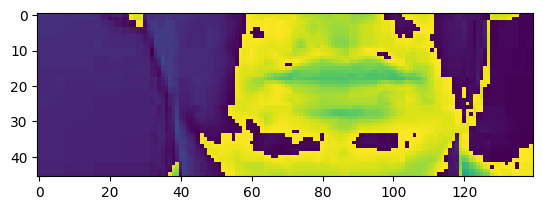

In [ ]:
plt.imshow(frames[0])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

### Creating Data Pipeline

In [16]:
import os
import tensorflow as tf

# Check directory contents
print(os.listdir('data\s1'))

# Try a more flexible file matching pattern
data = tf.data.Dataset.list_files("data\s1\*")
file_list = list(data.as_numpy_iterator())
print(file_list)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\s1'

In [20]:
data = tf.data.Dataset.list_files("data\s1\*.mpg")
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))    # lenght of each alignmets is going to be diffrent so we have padded it to make its lengh same for all 
data = data.prefetch(tf.data.AUTOTUNE)    # prefetchs data batches asynchronously during model training

train = data.take(450)
test = data.skip(450)

In [21]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)   ## now we have 2 videos in each batch

2

In [24]:
testx = data.as_numpy_iterator()

In [25]:
val = testx.next(); val[0]

array([[[[[ 1.4608315 ],
          [ 1.4608315 ],
          [ 1.5025696 ],
          ...,
          [10.643201  ],
          [ 0.08347609],
          [ 0.08347609]],

         [[ 1.4608315 ],
          [ 1.4608315 ],
          [ 1.5025696 ],
          ...,
          [10.643201  ],
          [ 0.08347609],
          [ 0.08347609]],

         [[ 1.3773555 ],
          [ 1.3773555 ],
          [ 1.4190935 ],
          ...,
          [ 0.        ],
          [10.643201  ],
          [10.643201  ]],

         ...,

         [[ 1.001713  ],
          [ 1.001713  ],
          [ 1.001713  ],
          ...,
          [10.43451   ],
          [10.43451   ],
          [10.43451   ]],

         [[ 1.001713  ],
          [ 1.001713  ],
          [ 1.001713  ],
          ...,
          [10.392773  ],
          [10.392773  ],
          [10.392773  ]],

         [[ 1.001713  ],
          [ 1.001713  ],
          [ 1.001713  ],
          ...,
          [10.392773  ],
          [10.392773  ],
          

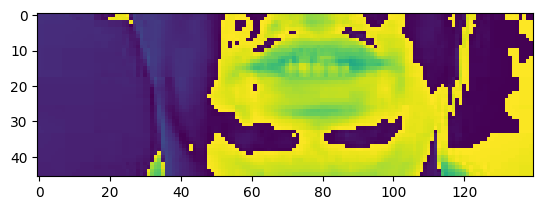

In [26]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][24])

In [27]:
directory = 'animations'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")

Directory 'animations' already exists.


In [28]:
# Create the animations directory if it doesn't exist
output_directory = ".\\animations"
os.makedirs(output_directory, exist_ok=True)

output_path = os.path.join(output_directory, "animation.gif")

# Rest of your code remains the same
video_frames = val[0][1]
video_frames = np.squeeze(video_frames)

num_frames, height, width = video_frames.shape
video_frames_uint8 = (video_frames * 255).astype(np.uint8)
video_frames_reshaped = np.reshape(video_frames_uint8, (num_frames, height, width))

imageio.mimsave(output_path, video_frames_reshaped, fps=10)

print(f"Animation saved successfully to: {output_path}")

Animation saved successfully to: .\animations\animation.gif


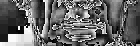

In [29]:
from IPython.display import Image

# Specify the path to the saved GIF
gif_path = '.\\animations\\animation.gif'

# Display the GIF
Image(filename=gif_path, width=400, height=300 , )

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green with z one again'>

### Designing the Deep Neural Netwok

In [31]:
# pip install --upgrade tensorflow 

In [32]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [34]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=(75, 40, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


# model.add(TimeDistributed(Flatten()))
model.add(Reshape(( 75, -1)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))

# model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer="he_normal", activation="softmax"))

n:\major project\lipnets\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 40, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 40, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 20, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 20, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 20, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 10, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 10, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 10, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture from the LipNet paper
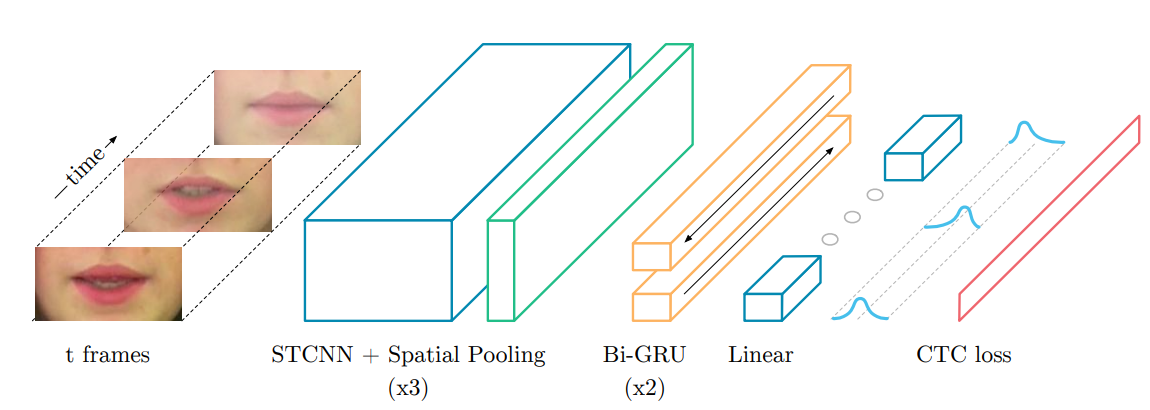
I have used BidirectionalLSTM instead of Bi-GRU

In [36]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'4aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa    '>

In [37]:
model.input_shape, model.output_shape

((None, 75, 40, 140, 1), (None, 75, 41))

### Seting up Traing options and Train the Model

In [38]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [39]:
def CTC_loss(y_true, y_pred): #https://keras.io/examples/audio/ctc_asr/
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [40]:
class produce_example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))




# class ProduceExampleCallback(tf.keras.callbacks.Callback):
#     def __init__(self, dataset):
#         super(ProduceExampleCallback, self).__init__()
#         self.dataset = dataset  # Assuming `dataset` is a TensorFlow dataset object

#     def on_epoch_end(self, epoch, logs=None):
#         # Get a batch of data from the dataset
#         data = next(iter(self.dataset.batch(1)))

#         inputs, targets = data[0], data[1]

#         # Make predictions using the model
#         predictions = self.model.predict(inputs)

#         # Decode predictions and targets to text
#         decoded_targets = tf.strings.reduce_join([vocab[word] + " " for word in targets[0]]).numpy().decode('utf-8')
#         decoded_predictions = tf.strings.reduce_join([vocab[word] + " " for word in predictions[0]]).numpy().decode('utf-8')

#         # Print original and predicted text
#         print(f"Original: {decoded_targets}")
#         print(f"Prediction: {decoded_predictions}")
#         print("-" * 50)

In [41]:
# from tensorflow.keras.optimizers.legacy import Adam

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTC_loss)

In [43]:
!mkdir models

A subdirectory or file models already exists.


In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [45]:
schedule_callback = LearningRateScheduler(scheduler)

In [46]:
example_callback = produce_example(test)

In [47]:
model.load_weights('models/checkpoint.weights.h5')

n:\major project\lipnets\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Testing the model

In [53]:
test_data = test.as_numpy_iterator()
sample = test_data.next()

In [55]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [56]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green at p two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y two now'>]

In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [58]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' set green at p two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' lay blue by y two now'>]

#### testing on a video

In [66]:
sample = load_data(tf.convert_to_tensor('.\\test\\brwg9a.mpg.mpg'))

In [67]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with g nine again'>]

In [61]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [62]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [63]:
decoded

array([[39,  2,  9, 14, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39,  7, 39,
        14,  9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' bin red with g nine again'>]